## Mask R-CNN Model

In [1]:
import cv2
import numpy as np
import colorsys
import time
from time import time as timer

cv2.__version__

'3.4.0'

In [2]:
import os
import sys
#import random
#import math
#import numpy as np
#import skimage.io
import matplotlib
import matplotlib.pyplot as plt
    
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
print(ROOT_DIR)
    
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import mrcnn.utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

/home/cfchen/Github36/Mask_RCNN-master


/home/cfchen/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Directory of images to run detection on
#IMAGE_DIR = os.path.join(ROOT_DIR, "images")
    
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()
    
print(ROOT_DIR)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

## Configurations

## Load Model

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

print(ROOT_DIR)

/home/cfchen/Github36/Mask_RCNN-master


## Functions

In [6]:
#############
# Functions #
#############

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    np.random.shuffle(colors)
    return colors

def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors

colors = random_colors(len(class_names))
class_dict = {
    name: color for name, color in zip(class_names, colors)
}

def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image

def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i in range(n_instances):
        '''
        Detect Only Person
        '''
        '''        
        if ids[i] != 1:
            continue
        '''
        '''
        Detect Only Person
        '''        
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        color = class_dict[label]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        #image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255,0), 5)
        #image = cv2.putText(image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2)
        image = cv2.putText(image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, (255, 255, 255), 2)

    return image

### Without Video Resizing

In [14]:
capture = cv2.VideoCapture('/media/cfchen/956df7bc-562e-4f24-8339-fd0b67f98888/Downloaded/VideosHPB/IMAG0011.mp4')
'''
size = (
    int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
    int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
)
'''

def re_scale(capture, percent=30):
    #width = int(frame.shape[1]  * percent / 100)
    #height = int(frame.shape[0] * percent / 100)
    width  =  int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)  * percent / 100)
    height =  int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT) * percent / 100)    
    dim = (width, height)
    return dim

re_scaled = re_scale(capture, 100)

def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('videofile_mask.avi',fourcc, 30.0, re_scaled)
#out = cv2.VideoWriter('output.avi',fourcc, 30.0, (1920,1080))

print("Video Dim: {}  {}  {}".format(capture.get(3), 'X', capture.get(4)))

Video Dim: 1920.0  X  1080.0


### Video

In [8]:
start = timer()

while(True):

    ret, frame = capture.read()
    
    if ret == True:

        #stime = time.time()
        #startFPS = timer()
        #results = model.detect([frame], verbose=0)  
        #print('FPS  {:.2f}  {}'.format(1 / (time.time() - stime), '\tElapsed time for each Frame = ' + str(timer() - startFPS) + ' s\n'))  

        #r = results[0]

        #frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])

        out.write(frame)        
        cv2.imshow('frame', frame)

        if (cv2.waitKey(1) & 0xFF == ord('q')) or (ret == False):
            break

    else:
        break

print('++++++++ Video End ++++++++')

capture.release()
out.release()
cv2.destroyAllWindows()

print('\nTotal elapsed time = ' + str(timer() - start) + ' s\n')

++++++++ Video End ++++++++

Total elapsed time = 6.7949347496032715 s



### Video (Downsample)

In [11]:
start = timer()

i = 0
frame_rate_divider = 3
while(True):

    ret, frame = capture.read()
    
    if ret == True:
        if i % frame_rate_divider == 0:

            #stime = time.time()
            #startFPS = timer()
            #results = model.detect([frame], verbose=0)  
            #print('FPS  {:.2f}  {}'.format(1 / (time.time() - stime), '\tElapsed time for each Frame = ' + str(timer() - startFPS) + ' s\n'))  

            #r = results[0]

            #frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])

            out.write(frame)        
            cv2.imshow('frame', frame)
            i += 1
        else:
            i += 1

        if (cv2.waitKey(1) & 0xFF == ord('q')) or (ret == False):
            break

    else:
        break

print('++++++++ Video End ++++++++')

capture.release()
out.release()
cv2.destroyAllWindows()

print('\nTotal elapsed time = ' + str(timer() - start) + ' s\n')

++++++++ Video End ++++++++

Total elapsed time = 3.3541431427001953 s



### Masked

In [13]:
start = timer()

count = 0;
while(True):
    ret, frame = capture.read() 
    
    if ret == True:

        count = count + 1

        '''
        # Re-size
        #frame = rescale_frame(frame, percent=30)
        #frame = cv2.resize(frame, (576, 324)) 
        frame = cv2.resize(frame, (640, 360)) 
        #print("Video Dim:  {}".format(frame.shape))
        # Re-size
        '''

        stime = time.time()
        startFPS = timer()
        results = model.detect([frame], verbose=0)
        print('FPS  {:.1f}  {}'.format(1 / (time.time() - stime), '\tElapsed time for each Frame = ' + str(timer() - startFPS) + ' s\n'))  

        r = results[0]
    
        frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
        
        out.write(frame)
        
        cv2.imshow('frame', frame)
        
        if (cv2.waitKey(1) & 0xFF == ord('q')) or (ret == False):
            break

    else:
        break
        
print('++++++++ Video End ++++++++')
  
capture.release()
out.release()
cv2.destroyAllWindows()

print('\nTotal elapsed time = ' + str(timer() - start) + ' s\n')

FPS  0.3  	Elapsed time for each Frame = 3.507929801940918 s

FPS  3.0  	Elapsed time for each Frame = 0.33607912063598633 s

FPS  3.3  	Elapsed time for each Frame = 0.3068854808807373 s

FPS  3.0  	Elapsed time for each Frame = 0.3350534439086914 s

FPS  3.2  	Elapsed time for each Frame = 0.3146355152130127 s

FPS  2.9  	Elapsed time for each Frame = 0.34566497802734375 s

FPS  3.2  	Elapsed time for each Frame = 0.3110198974609375 s

FPS  3.2  	Elapsed time for each Frame = 0.31348466873168945 s

++++++++ Video End ++++++++

Total elapsed time = 8.949597358703613 s



### Masked  (Downsample)

In [15]:
start = timer()

i = 0
frame_rate_divider = 3
while(True):
    ret, frame = capture.read() 
    
    if ret == True:
        if i % frame_rate_divider == 0:

            '''
            # Re-size
            #frame = rescale_frame(frame, percent=30)
            #frame = cv2.resize(frame, (576, 324)) 
            frame = cv2.resize(frame, (640, 360)) 
            #frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
            #print("Video Dim:  {}".format(frame.shape))
            # Re-size
            '''

            stime = time.time()
            startFPS = timer()
            results = model.detect([frame], verbose=0)
            print('FPS  {:.1f}  {}'.format(1 / (time.time() - stime), '\tElapsed time for each Frame = ' + str(timer() - startFPS) + ' s\n'))  

            r = results[0]
    
            frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
        
            out.write(frame)
            cv2.imshow('frame', frame)
            i += 1
        else:
            i += 1
        
        if (cv2.waitKey(1) & 0xFF == ord('q')) or (ret == False):
            break

    else:
        break
        
print('++++++++ Video End ++++++++')
  
capture.release()
out.release()
cv2.destroyAllWindows()

print('\nTotal elapsed time = ' + str(timer() - start) + ' s\n')

FPS  3.0  	Elapsed time for each Frame = 0.3283705711364746 s

FPS  3.0  	Elapsed time for each Frame = 0.33387136459350586 s

FPS  3.3  	Elapsed time for each Frame = 0.301663875579834 s

FPS  3.2  	Elapsed time for each Frame = 0.311445951461792 s

FPS  3.4  	Elapsed time for each Frame = 0.29250288009643555 s

FPS  3.2  	Elapsed time for each Frame = 0.3094029426574707 s

FPS  3.4  	Elapsed time for each Frame = 0.2973318099975586 s

FPS  3.2  	Elapsed time for each Frame = 0.3149726390838623 s

FPS  3.3  	Elapsed time for each Frame = 0.3031177520751953 s

FPS  3.4  	Elapsed time for each Frame = 0.2957775592803955 s

FPS  3.2  	Elapsed time for each Frame = 0.3167107105255127 s

FPS  3.3  	Elapsed time for each Frame = 0.30027294158935547 s

FPS  3.3  	Elapsed time for each Frame = 0.3071756362915039 s

FPS  3.4  	Elapsed time for each Frame = 0.29789233207702637 s

FPS  3.2  	Elapsed time for each Frame = 0.3137679100036621 s

FPS  3.5  	Elapsed time for each Frame = 0.2853095531

### With Video Resizing

In [16]:
capture = cv2.VideoCapture('/media/cfchen/956df7bc-562e-4f24-8339-fd0b67f98888/Downloaded/VideosHPB/IMAG0011.mp4')

re_scaled = re_scale(capture, 30)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
#out = cv2.VideoWriter('videofile_mask_resized.avi',fourcc, 30.0, re_scaled)
out = cv2.VideoWriter('videofile_mask_resized.avi',fourcc, 30.0, (640,360))

print("Video Dim: {}  {}  {}".format(capture.get(3), 'X', capture.get(4)))

Video Dim: 1920.0  X  1080.0


## Pictures

## Run Detection

In [17]:
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "valimages")
IMAGE_DIR

'/home/cfchen/Github36/Mask_RCNN-master/valimages'

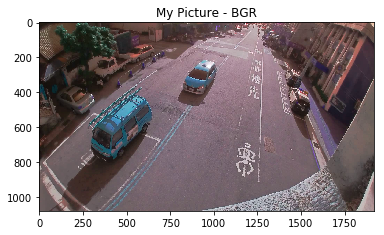

In [18]:
#import skimage.io

# Load a random image from the folder
file_names = next(os.walk(IMAGE_DIR))[2]

#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
#image = cv2.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image = cv2.imread(os.path.join(IMAGE_DIR, file_names[3]))
'''
cv2.imshow('image',image)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''
#image = cv2.imread('/home/cfchen/Github36/Mask_RCNN-master/valimages/COCO_val2014_000000393243.jpg')

plt.imshow(image)
plt.title('My Picture - BGR')
plt.show()

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


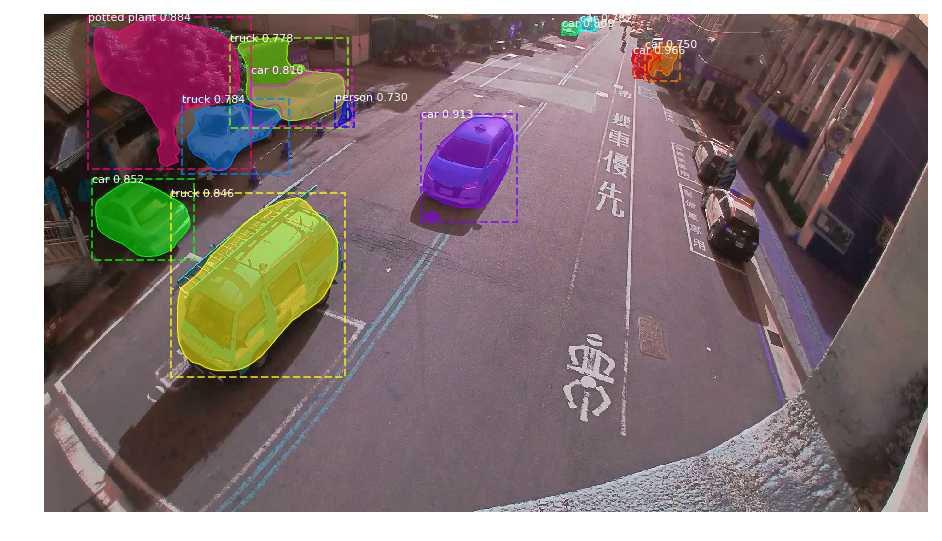

In [19]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

### Precision-Recall

### Compute mAP @ IoU=50 on Batch of Images